In [1]:
from collections import defaultdict

from graphviz import Digraph, Graph
import matplotlib.pyplot as plt

import re

from itertools import chain, combinations


REGEX = r'(?:\((?P<sub00>.*)\) )*(?P<op>\w+)(?: (?P<sub01>\w+))* ?\((?P<sub1>.*)\)'

R = re.compile(REGEX)

In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def info(proposition) :
    return {w for s in proposition for w in s}

def parse(string, r) :
    [m.groupdict() for m in r.finditer(string)]

In [48]:
class formula() : 
    def __init__(self, op = None, subform = []) :
        self.op = op
        self.subform = subform
        
    def from_string(self, string):
        # extract operator and subformulas (as strings) from dict
        d = [m.groupdict() for m in R.finditer(string)]
        if not d : 
            if string.isdigit() :
                string = int(string)
            return string
        d = d[0]
        if d['sub00'] :
            sub0 = d["sub00"]
        elif d["sub01"] :
            sub0 = d["sub01"]
        else :
            self.op = "atomic"
            sub1 = d["sub1"]
            if sub1.isdigit() :
                sub1 = int(sub1)
            self.subform = [d["op"], sub1]
            return self
        self.op = d["op"]
        sub1 = d["sub1"]
        self.subform = [formula().from_string(sub0), formula().from_string(sub1)]
        return self
    
    def substitute(self, x, y) :
        if self.op == "atomic" :
            pred = self.subform[0]
            var = self.subform[1]
            if var == x:
                var = y
            return formula(self.op, [pred,var])
        new_sub = []
        for form in self.subform :
            if type(form) != type(self) :
                new_sub.append(form)
            else :
                new_sub.append(form.substitute(x,y))
        return formula(self.op, new_sub)

    def all_subform(self) :
        return
    
    def __repr__(self) -> str:
        return f"({self.op} : {self.subform}) "

In [51]:
t1 = "P(2)"
t2 = "(P(2)) and (P(3))"
t3 = "forall x (P(x))"
t4 = f"K 1 ({t3})"

print(formula().from_string(t4))

(K : [1, (forall : ['x', (atomic : ['P', 'x']) ]) ]) 


In [4]:
class model_IEL() :
    def __init__(self, W=set(), D=set(), R=dict()) :
        self.W = W
        self.D = D
        self.R = R
        
class model_DEL() :
    def __init__(self, W=set(), R=defaultdict(lambda: set()), V=defaultdict(lambda: set())) :
        self.W = W
        self.R = R
        self.V = V
        
    def add_world(self, w) :
        self.W.add(w)
        self.R[w].add(w)
        
    def add_relation(self,w,v) :
        if w in self.W and v in self.W :
            self.R[w].add(v)
        else :
            print(f"{w} in W : {w in self.W}, \n{v} in W : {v in self.W}")
            
    def add_val(self,prop,w) :
        if w in self.W :
            self.V[prop].add(w)
            
    def true(self, formula, w) : 
        if formula.op == "prop" :
            return (w in V[formula.subform[0]])
        if formula.op == "AND" :
            return (self.true(formula.subform[0],w) and self.true(formula.subform[1],w))
        if formula.op == "NEG" : 
            return not self.true(formula.subform[0],w)
        if formula.op == "BOX" :
            return all(self.true(formula.subform[0],x) for x in self.R[w])
        if formula.op == "K" :
            return all(self.true(formula.subform[0],x) for x in self.W)
        if formula.op == "B" :
            return 
        
            
    def build_minimal_model(self, formula) :
        pass
    
    def diff(self, w, v) :
        return
    
    def draw(self, w = None) :
        g = Digraph()
        if w :
            return 
        else :
            for node in self.W :
                val = [p for p in self.V.keys() if node in self.V[p]]
                g.node(str(node), f"w{node}\n{val}")
                for target in self.R[node] :
                    g.edge(str(node),str(target))
            return g
    
    def __repr__(self) :
        return f"W : {self.W } \nR : {self.R.items()} \nV : {self.V.items()}"
    
    
class model_Inq_plaus() :
    def __init__(self, W=[], D=[], A=[], I=None, R = None, E = None) : 
        self._W = set(W)
        self._D = set(D)
        self._A = set(A)
        if not R :
            self._R = defaultdict(lambda:defaultdict(lambda: set()))
        else: 
            self._R = R
        if not I :
            self._I = defaultdict(lambda:{})
        else :
            self._I = I
        if not E :
            self._E = defaultdict(lambda:defaultdict(lambda: set()))
        else :
            self._E = E
        
    def add_world(self, w) :
        self._W.add(w)
        [self._R[i][w].add(w) for i in self._A]
        # TODO: Make sure that all constants will get I(w)(c) = d (rigidity)
        # If we even need individual constants
        
    def add_element(self, d) :
        self._D.add(d)
        
    def add_agent(self, i) :
        self._A.add(i)
        [self._R[i][w].add(w) for w in self._W]

    def add_constant(self, c, d) :
        self._D = self._D.union({d})
        for w in self._W :
            self._I[w][c] = d
        
    def set_I(self, w, Pred, ds) :
        self._D = self._D.union(set(ds))
        self._I[w][Pred] = set(ds)
    
    # Possibly relations can be replaced with sets of plausibility (spheres)
    #           -> Spheres = Alexandroff topology on K
    def add_relation(self, i, w, v) :
        if w in self._W and v in self._W and i in self._A:
            self._R[i][w].add(v)
            # make sure remains transitive
            for u in self._R[i][v] :
                self._R[i][w].add(u)
            # could use a workaround possibly
            for u in self._R[i] :
                if w in self._R[i][u] :
                    self._R[i][u].add(v)
        else :
            print(f"{w} in W : {w in self._W}, \n{v} in W : {v in self._W}, \n{i} in A : {i in self._A}")
            
    # This should be a mapping for each agent, so each world should have a issue
    def set_inq_state(self, i, issue) :
        for w in info(issue) :
            self._E[i][w] = issue
        
    def refine_inq(self, i, w, issue) :
        pass
    
    def get_epi_state(self, i, w) :
        return info(self._E[i][w])
    
    
    def proposition(self, form):
        sub = form.subform
        if form.op == "atomic" :
            #truth_set = {w for w in self._W if formula.subform[1] in self._I[w][formula.subform[0] if formula.subform[0] in self._I[w]]}
            truth_set = set()
            for w in self._W :
                if (pred:= sub[0]) in (Iw:=self._I[w]) :
                    if sub[1] in Iw[pred] :
                        truth_set.add(w)
            #powerset
            return set(powerset(truth_set))
        
        if form.op == "and" :
            return self.proposition(sub[0]) & self.proposition(sub[1])
        
        if form.op == "or" :
            return self.proposition(sub[0]) | self.proposition(sub[1])
        
        if form.op == "neg" :
            return set(powerset(self._W - info(self.proposition(sub[0]))))
        
        if form.op == "to" :
            return { s for s in powerset(self._W) if not any(t in self.proposition(sub[0]) and t not in self.proposition(sub[1]) for t in powerset(s))}
        
        if form.op == "forall" :
            # subform[0] = variable, subform[1] is the formula
            sub = form.subform
            intersect = set(powerset(self._W))
            for d in self._D :
                intersect = intersect & self.proposition(sub[1].substitute(sub[0], d))
            return intersect
        
        if form.op == "exists" :
            sub = form.subform
            union = set()
            for d in self._D :
                union = union | self.proposition(sub[1].substitute(sub[0], d))
            return union
            # return {*self.proposition(sub[1].substitute(sub[0],d)) for d in self._D}
        
        if form.op == "?" :
            #return self.proposition(formula.subform[0]) | self.proposition(formula("neg", [formula.subform[0]]))
            return self.proposition(formula(op = "or", subform=[sub[0], formula(op="neg",subform=[sub[0]])]))

        if form.op == "!" :
            # return self.proposition(formula("neg", [formula("neg", [sub[0]])]))
            return set(powerset(info(self.proposition(sub[0]))))
        
        # Epistemic/Doxastic K/B
        if form.op == "K" :
            i = sub[0]
            # e = {self.get_epi_state(i,w) for w in self._W}
            #return {s for s in powerset(self._W) if all(self.get_epi_state(i,w) in self.proposition(sub[1]) for w in s)}
            #return set(powerset({w for s in e if (e:=self.get_epi_state(i,w)) in self.proposition(sub[1]) for w in s }))
            # pprint(self.proposition(sub[1]))
            # print(self._E[i])
            states = {e for w in self._W if (e:=tuple(self.get_epi_state(i,w))) in self.proposition(sub[1])}
            return set(powerset(info(states)))

        if form.op == "B" :
            i = sub[0]
            pass

        # Inquisitive wonder "W"
        if form.op == "W" :
            i = sub[0]
            pass

        # Temporal operators "BoxF" "BoxP"
        
    def support(self, s, form) :
        sub = form.subform
        if form.op == "atomic" :
            return tuple(s) in self.proposition(form)
        
        if form.op == "and" :
            return self.support(s,sub[0]) and self.support(s,sub[1])
        
        if form.op == "or" :
            return self.support(s,sub[0]) or self.support(s,sub[1])
        
        if form.op == "neg" :
            return not any(self.support(t,sub[0]) for t in powerset(s) if t != ())
        
        if form.op == "to" :
            return all(self.support(t,sub[1]) for t in powerset(s) if self.support(t,sub[0]))

        if form.op == "exists" :
            return any(self.support(s,sub[1].substitute(sub[0], d)) for d in self._D)
        
        if form.op == "forall" :
            return all(self.support(s,sub[1].substitute(sub[0], d)) for d in self._D)
        
        if form.op == "?" :
            return self.support(s,sub[0]) or self.support(s, formula("neg",[sub[0]]))
        
        if form.op == "!" :
            return self.support(s,formula=("neg",[formula("neg",[sub[0]])]))
        
        if form.op == "K" :
            return all(self.support(self._E[sub[0]][w], sub[1]) for w in s)


    def from_formula(self, form) :
        # builds minimal model from formula
        pass
            
            
    def draw(self, w = None, agents = None) -> Digraph:
        SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
#         SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
        if not agents :
            agents = self._A
        g = Digraph()
        if w :
            return 
        else :
            for node in self._W :
#                 val = [p for p in self.V.keys() if node in self.V[p]]
                g.node(str(node), f"w{node}".translate(SUB))
                g.edge(str(node), str(node))
                for i in agents :
                    for target in self._R[i][node] :
                        if target != node :
                            g.edge(str(node),str(target),label=f"a{i}".translate(SUB))
            return g
        
    def draw_proposition(self, proposition, g=None, alt_only=False) -> Digraph :
        # in case you want to give a model/graph and want to draw propositions over it
        SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
        if g :
            return
        else :
            g = Digraph()
            for node in self._W :
                g.node(str(node), f"w{node}".translate(SUB))
            for s in proposition :
                sub_g = Digraph()
                for w in s :
                    sub_g.node(str(w), str(w))
                sub_g.attr(style='filled', color='lightgrey', fillcolor = "lightgrey", label = str(s))
                g.subgraph(sub_g)

            # with g.subgraph(name='cluster_0') as c:
            #     c.attr(style='filled', color='lightgrey')
            #     c.node_attr.update(style='filled', color='white')
            #     c.edges([('w\n {p}', 'v\n {p}'), ('v\n {p}', 'v\n {p}')])
            #     c.attr(label='M')
            return g
            
    

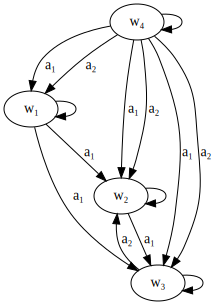

In [5]:
M1 = model_Inq_plaus()

M1.add_world(1)
M1.add_world(2)
M1.add_world(3)

M1.add_agent(1)
M1.add_agent(2)

# add_relation: i, x, y -> x R_i y
M1.add_relation(1,1,2)
M1.add_relation(1,2,3)
M1.add_relation(2,3,2)

M1.add_world(4)
M1.add_relation(2,4,3)

M1.add_relation(1,4,2)
M1.add_relation(1,4,1)

M1.add_relation(2,4,1)

M1.draw()

In [6]:
M1.add_constant("john",1)
M1.add_world(5)
M1.set_I(1,"P",{1,2})
M1.set_I(2,"P",{1,2,3})
M1.set_I(3,"P",{1,2,3})

for w in [2,3,4]:
    M1.set_I(w,"Q",M1._D)

form = formula(op = "atomic", subform = ["P",2])
form1 = formula(op = "atomic", subform = ["Q",2])
form2 = formula(op = "and", subform = [form,form1])
form3 = formula(op= "?", subform=[form])
form4 = formula(op= "!", subform=[form3])
form5 = formula(op = "to", subform=[form, form4])
form6 = formula(op= "forall", subform=["x",formula(op="atomic", subform=["P","x"])])
form7 = formula(op= "K", subform=[1,form3])
print(M1.proposition(form5))
M1.support([4], formula(op="?", subform=[form3]))

{(2,), (3, 4), (5,), (1, 2, 3, 4), (1, 2, 5), (2, 5), (1, 3), (1, 4, 5), (2, 4, 5), (4,), (1,), (4, 5), (2, 3, 4, 5), (1, 2, 3, 4, 5), (1, 2, 4), (1, 2, 4, 5), (2, 4), (1, 2), (1, 3, 4, 5), (1, 5), (1, 3, 5), (2, 3, 5), (3,), (3, 5), (1, 2, 3, 5), (1, 2, 3), (1, 4), (1, 3, 4), (2, 3), (3, 4, 5), (2, 3, 4), ()}


True

In [7]:
M1.set_inq_state(1,M1.proposition(form))
print(M1.get_epi_state(1,2))
for s in M1.proposition(form7) :
    print(M1.support(s, form7))

{1, 2, 3}
True
True
True
True
True
True
True
True


In [8]:
form7

(K : [1, (? : [(atomic : ['P', 2]) ]) ]) 

In [9]:
f2 = formula(op="neg",subform=[form1])
f3 = formula(op="and", subform=[form,f2])

M1.proposition(f3)

{(), (1,)}

In [10]:
f = formula(op="forall",subform=["x", formula(op="atomic", subform=["P","x"])])
for d in [1,2,3] :
    print(f.subform[1].substitute(f.subform[0],d))

(atomic : ['P', 1]) 
(atomic : ['P', 2]) 
(atomic : ['P', 3]) 


In [11]:

f  = "exists x(P(x) and Q(x))"

sub = formula
formula(op= "exists", subform=["x",sub])

(exists : ['x', <class '__main__.formula'>]) 

In [12]:
f = "(forall x (Q(x))) and (P(2))"
f2 = "(P(2)) and (exists x (Q(x)))"
r = re.compile(REGEX)
# res = re.findall(r, f)
# print(res)
# res = [x for x in res[0] if x]
# res

d = [m.groupdict() for m in r.finditer(f2)][0]
f3 = d['sub1']

In [19]:
pattern = r'(\w+) \(.*\)'
pattern2 = r'\((.*)\)'
t = "(2)"
t1 = "P(2)"
t2 = "(P(2)) and (P(3))"
t3 = "exists x (P(x))"
print(re.findall(pattern, t3))
print(re.findall(pattern2, t3))

['x']
['P(x)']


In [20]:
fo = formula().from_string(t2)

In [21]:
fo